# Compute the style of an image

Based on the paper by Gatis et al. 2016 ([ref](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)).


In [31]:
# Imports
import torch
import torchvision
from torch import nn
import skimage
from skimage import transform
from im_func import show_image, timer
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Get images

In [2]:
im = skimage.data.coffee()
# im = skimage.transform.rescale(im, 0.25, anti_aliasing=False, multichannel=True)
# _ = show_image(im)
# im.max()
# im = im/255.
# im = im.astype(np.float32)

# Pre/post processing of image

Normalization, resizing etc... to correspond to the input format of images trained by t

In [3]:
# From D2L
im_shape = (150, 225)
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)

def postprocess(img):
#     img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [4]:
# Apply pre-proc to image
im_new = preprocess(im,im_shape)

# Get a pretrained model

In [5]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

In [6]:
pretrained_net.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Defined the image generator network and a function to make a partial pass through the network

In [7]:
class ImageGenerator(nn.Module):
    def __init__(self,shape):
        super(ImageGenerator,self).__init__()
        self.im = nn.Parameter(torch.rand(1, 3, *shape))
    def forward(self):
        return self.im

In [8]:
# Apply layer by layer mods
def partial_forward(input_im,n_layer):
    X = input_im
    for il in range(n_layer):
        X = pretrained_net.features[il](X)
    return X

def visu_im_rep(X, ncol=5):
    nrow = int(np.ceil(n_channels/ncol))
    fig, ax = plt.subplots(nrow,ncol,figsize=[15,24],tight_layout=True)
    with torch.no_grad():
        for ic in range(n_channels):
            plt.sca(ax[np.unravel_index(ic,(nrow,ncol))])
            show_image(X[0,ic,:,:])

`x` is the representation of our input image by the given layer. This representation is composed of many channels, each the result of a specific convolution that has been optimized through training to extract specific useful features. 
Now, we instantiate the simple ImageGenerator. `im_gen` parameters' (`list(im_gen.parameters())[0]`) contains a tensor initialized with random noise. 

In [9]:
# len(pretrained_net.features)
pretrained_net.named_parameters

<bound method Module.named_parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256

# Compute style

In [10]:
# def partial_forward_style_loss(style_im, gen_im, n_layer):
#     a = style_im
#     x = gen_im
#     w = 1./n_layer # placeholder
#     loss = 0
#     print(n_layer)
#     all_losses = np.array([])
#     l0 = 0
#     for il in range(n_layer):
#         a = pretrained_net.features[il](a)
#         x = pretrained_net.features[il](x)
#         fac = 1./(2.*a.shape[1]*a.shape[2]*a.shape[3])**2
#         A = a.reshape(a.shape[1],-1) 
#         G = x.reshape(x.shape[1],-1) 
#         A = A@A.T # Gram matrix
#         G = G@G.T
# #         l0 = w*fac*torch.sum((A-G)**2)
# #         if il == 0:
#         l0 = w*fac*torch.sum((A-G)**2) 
# #         elif il == 1:
# #             l1 = w*fac*torch.sum((A-G)**2)
#     print(l0)
#     loss = l0
    

#     return loss

In [25]:
def partial_forward_style_loss(style_im, gen_im, n_layer):
    a = style_im.detach()
    x = gen_im
    w = 1./n_layer # placeholder
    loss = 0
    all_losses = np.array([])
    l0 = 0
#     print(a.max())
    
    
    
    for il in range(n_layer):
        a = pretrained_net.features[il](a)
        x = pretrained_net.features[il](x)
    
    fac = 1./(a.shape[1]*a.shape[2]*a.shape[3])
    
#     print(a.max())
#     print(x.max())
    
    aa = a.reshape(a.shape[1],-1) 
    xx = x.reshape(x.shape[1],-1) 
    
#     xx = (xx-aa.mean())/aa.std()
#     aa = (aa-aa.mean())/aa.std()
    
#     print(aa.max())
    
    A = torch.matmul(aa,aa.T)#*fac # Gram matrix

    
    G = torch.matmul(xx,xx.T)#*fac
    
#     A_mean = A.mean()
#     A_std = A.std()
    
#     A = (A-A_mean)/A_std
#     G = (G-A_mean)/A_std
    
#     print(A.shape)
#     print(G.shape)
#     l0 = w*fac*torch.sum((A-G)**2) 
    l0 = torch.mean(((A-G)/torch.mean(A))**2)
#     l0 = torch.mean((A.detach()-G)**2)
#     l0 = fac*torch.sum(((A-G)/torch.mean(A))**2)
    
#     print(l0)
    loss = l0
    
#     print(loss)
    return loss

# Train

In [49]:
im_gen = ImageGenerator(im_shape)
# current_im = im_gen()
# preprocess(current_im,im_shape).shape
layer = 3
im_style = preprocess(im,im_shape)
# target_rep = partial_forward(preprocess(im,im_shape), layer)
# loss_fn = MSE_TV_loss
optim = torch.optim.LBFGS(im_gen.parameters())
# optim = torch.optim.Adam(im_gen.parameters())
# Stopping criterion
abs_loss_limit = 1e-10
rel_loss_limit = 1e-12

In [50]:
im_generated = im_gen()
loss = partial_forward_style_loss(im_style, im_generated, layer)

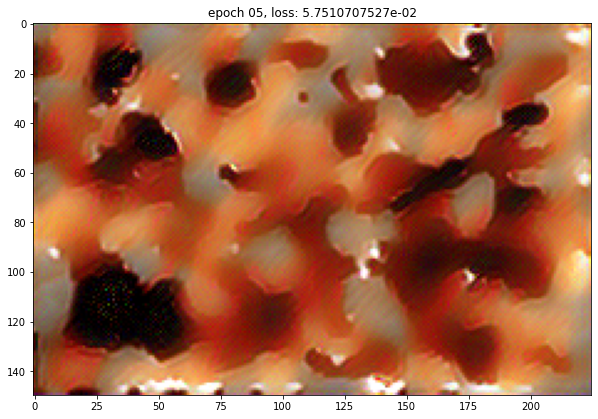

KeyboardInterrupt: 

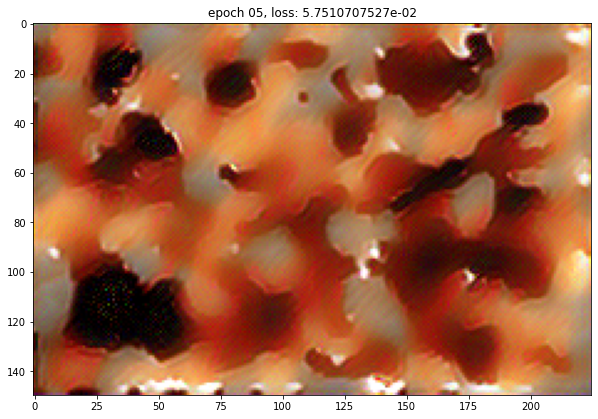

In [52]:
# train
fig, ax = plt.subplots(1,1,figsize=[10,10])

def closure():
#     if torch.is_grad_enabled():
    im_generated = im_gen()
    optim.zero_grad()
    loss = partial_forward_style_loss(im_style, im_generated, layer)
    loss.backward()
    return loss

last_loss = 1e10
for i in range(100):    
#     im_generated = im_gen()
    optim.step(closure)
    if i%1==0:
        with torch.no_grad():
            im_generated = im_gen()
            loss = partial_forward_style_loss(im_style, im_generated, layer)
            
#             print(f"epoch {i:02d}, loss: {loss:.10e}")
            
            
            imnew = postprocess(im_generated[0])
            ax.cla()
            plt.imshow(imnew)
            plt.title(f"epoch {i:02d}, loss: {loss:.10e}")
            clear_output(wait = True)
            display(fig)

            if loss<abs_loss_limit:
                clear_output(wait = True)
                print(f'success: absolute loss limit ({abs_loss_limit:.1e}) reached')
                break
            if torch.abs(last_loss-loss)<rel_loss_limit:
                clear_output(wait = True)
                print(f'stopped because relative loss limit ({rel_loss_limit:.1e})  was reached')
                break
                
            last_loss = loss